# Michelson Interferometer experiment

Version 1.0 based on code from Will Thompson and Sean Musclow, modified by R. Knobel


Student Name:

Student Name:



### Import libraries
Here we set up the graphics, load **matplotlib** for graphing, **numpy** for manipulating data.  **Scipy** has some specialized and advanced tools for data analysis, including a robust peak-finding routine we'll use. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.optimize
import uncertainties as u

ModuleNotFoundError: No module named 'uncertainties'

## Using the oscilloscope to record signals in the Interferometer.

Let's use the oscilloscope function of the STEMlab instrument to record the change in the detected optical signal .

We'll use the Red Pitaya STEMlab as an oscilloscope.  Connect it using a micro-usb power adapter and ethernet cable as shown below
<img src="https://i.imgur.com/0NqLiT6.png" />
To connect to the oscilloscope, open the following web page (in another tab than this) on your laptop:
http://labs.phy.queensu.ca/rpXX
where XX is the number taped to the top of the STEMlab. Start the Oscilloscope and Signal Generator app.

You can load the data in to this notebook using the "loadtxt" function in numpy.  **Change the filename below to the filename of your data.**

In [16]:
data = np.loadtxt('RGKscope_1.csv', delimiter=',',skiprows=1) #skip the header row

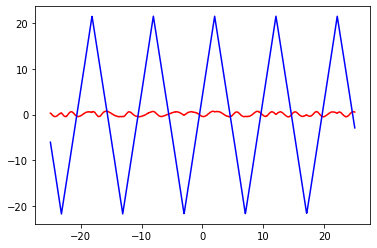

In [17]:
time = data[:,0]
plt.plot(time, data[:,1],'r', label='Photodiode Voltage')
plt.plot(time, data[:,2]*10,'b', label='Function Generator Voltage')
plt.show()

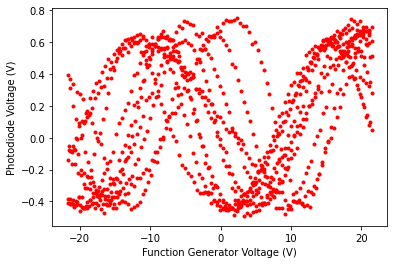

In [19]:
def fit_func(x, a, b, c):
    return a*np.sin(2*np.pi*x + b) + c

#create array of voltages for one period
voltageIN = data[:,2]*10
photoV = data[:,1]
#plot the voltages
plt.plot(voltageIN, photoV, 'r.')
plt.xlabel('Function Generator Voltage (V)')
plt.ylabel('Photodiode Voltage (V)')
plt.show()

Note that the vertical scale in the exported data is given in divisions on the oscilloscope screen.  In order to measure this in volts, you must record the scales used.

## Python control of STEMlab

In the next section we'll connect directly to the STEMlab from python and take the voltage of the photodiode as a function of the driving voltage.  This can be really useful for your projects, where you may want to take data automatically.  Information on how to do this is available linked through OnQ.

**To connect to the STEMlab make sure there is a file called 'qredpitaya.py' in the same directory as this notebook.**

In [4]:
from qredpitaya import ConnectRedPitaya, convert_scpi_list_to_array
import time

## Connect your Notebook to the Red Pitaya

The STEMlab/Red Pitaya is useful as a stand alone instrument.  However its power becomes evident when you program the instrument to send data beyond what the stand alone apps can do.  The simplest way to do this is demonstrated here.

Use the Standard Commands for Programmable Instruments protocol (**SCPI**, pronounced *skippy*) protocol over the network to issue commands and query variables.  The SCPI interface is described in the system documentation at http://redpitaya.readthedocs.io/en/latest/appsFeatures/remoteControl/remoteControl.html .

Turn on the SCPI server on the STEMlab using the browser tab that ran the oscilloscope.  Go to the main menu for the STEMlab and select "Development".
<img src="http://redpitaya.readthedocs.io/en/latest/_images/scpi-homepage.png" width=500/>

Select "SCPI Server"
<img src="http://redpitaya.readthedocs.io/en/latest/_images/scpi-development.png" width=500/>
Start the server
<img src="http://redpitaya.readthedocs.io/en/latest/_images/scpi-app-run.png" width=500/>.

Start by connection to your Red Pitaya. Use verbose=True to see the commands sent over the network.

To access the STEMlab on your desk, ensure it is connected to the lab ethernet network, then its address to communicate by SCPI is **labs.phy.queensu.ca** with port number **600XX** where **XX** is the number taped to the top of the instrument in its IP address **rpXX**.  The qredpitaya package includes commands to control the instrument over SCPI.  Note that this control doesn't have to be solely through Python (Matlab, LabView or other programming languages can also work).

In [5]:
#rp = ConnectRedPitaya('labs.phy.queensu.ca/rp31',port=5000,verbose=True)  # Connect this way in general, changing port for your device
rp = ConnectRedPitaya('192.168.0.31',port=5000,verbose=True)  # This can work for desktop computers in the lab
#rp = ConnectRedPitaya('192.168.128.1',port=5000,verbose=True)  # This if you use the wifi dongle as a hotspot on the STEMlab

192.168.0.31 <-- *RST 
192.168.0.31 <-- *CLS 
192.168.0.31 <-- *IDN? 
192.168.0.31 --> REDPITAYA,INSTR2020,0,01-02 
Connected to REDPITAYA,INSTR2020,0,01-02


## Reset Red Pitaya Acquire Module
Run this cell to reset the acquire module of the Red Pitaya.


In [6]:
rp.flush()
rp('ACQ:RST')

192.168.0.31 <-- ACQ:RST 


## Capture Interference fringes

Below is the main cell for data acquisition.  Here you read the driving voltage on Channel 2 and the photodiode signal on channel 1.  Data is saved to the filename at the end of the cell.

192.168.0.31 <-- ACQ:RST 
192.168.0.31 <-- ACQ:DATA:FORMAT ASCII 
192.168.0.31 <-- ACQ:DATA:UNITS VOLTS 
192.168.0.31 <-- ACQ:DEC 64 
192.168.0.31 <-- ACQ:TRIG:LEV 0.01 
192.168.0.31 <-- ACQ:TRIG:LEV 0.01 
192.168.0.31 <-- ACQ:START 
192.168.0.31 <-- ACQ:TRIG CH2_PE 
192.168.0.31 <-- ACQ:TRIG:STAT? 
192.168.0.31 --> TD 
192.168.0.31 <-- ACQ:SOUR1:DATA? 
192.168.0.31 --> {-0.0728274,-0.0720554,-0.072184,-0.0715407,-0.072184,-0.0716693,-0.0719267, ...
192.168.0.31 <-- ACQ:SOUR2:DATA? 
192.168.0.31 --> {-0.15489,-0.15489,-0.155019,-0.155019,-0.155019,-0.155148,-0.155148,-0.1554 ...


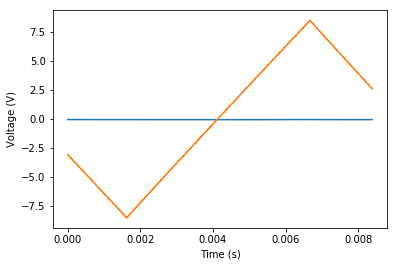

In [7]:
# Example acquiring data from https://redpitaya.readthedocs.io/en/latest/appsFeatures/examples/acqRF-exm1.html
# modified to work using q redpitaya package.
#
# Want to trigger on channel 2 and record both channel 1 and channel 2 data

rp('ACQ:RST')

# here is some code to generate a signal - commented out 
#rp('GEN:RST')

#rp('SOUR1:FUNC TRIANGLE')
#rp('SOUR1:FREQ:FIX 1000')
#rp('SOUR1:VOLT 1')

#Enable output
#rp('OUTPUT1:STATE ON')
#rp('SOUR1:TRIG:INT')


rp('ACQ:DATA:FORMAT ASCII')
rp('ACQ:DATA:UNITS VOLTS')

# Time axis binning in increments of 8ns. Larger values mean longer captures are taken,
# but with less detail (always 16384 samples)

# for 1, each data point is a single 8 ns reading.  The whole data set is 131 microseconds long.
# for 8, each data point is an average of 8*8ns readings, taking 64 ns.  The whole data set is 1.05 ms long. 
# for 64, each data point is an average of 64*8ns readings, taking 512 ns.  The whole data set is 8.39 ms long.
# for 1024, each data point is an average of 1024*8ns readings, taking 8.192 us.  The whole data set is 134 ms long.
# for 8192, each data point is an average of 8192*8ns readings, taking 65.5 us.  The whole data set is 1.07 s long.
# for 65536, each data point is an average of 65536*8ns readings, taking 524 us.  The whole data set is 8.59 s long.

adc_decimation = 64                   # 1, 8, 64, 1024, 8192, 65536

rp("ACQ:DEC {adc_decimation}".format(**locals()))

t = np.arange(0,16383*8.0e-9*adc_decimation,8.0e-9*adc_decimation)

rp('ACQ:TRIG:LEV 0.01')
rp('ACQ:TRIG:LEV 0.01')

rp('ACQ:START')
rp('ACQ:TRIG CH2_PE')
#time.sleep(1.05)

while 1:
    time.sleep(0.05)
    if rp('ACQ:TRIG:STAT?') == 'TD':
        break

## FUTURE BETA
# while 1:
#     rp_s.tx_txt('ACQ:TRIG:FILL?')
#     if rp_s.rx_txt() == '1':
#         break

#time.sleep(1.05)

buff_string = rp('ACQ:SOUR1:DATA?')
buff_string = buff_string.strip('{}\n\r').replace("  ", "").split(',')
v1 = np.asarray(buff_string, dtype=float)

buff_string = rp('ACQ:SOUR2:DATA?')
buff_string = buff_string.strip('{}\n\r').replace("  ", "").split(',')
np.array(map(float, buff_string))
v2 = 20* np.asarray(buff_string, dtype=float)

plt.plot(t,v1)
plt.plot(t,v2)
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()


# Save the data
rp.flush()

filename = "testdata_interferometer.csv"
np.savetxt(filename,np.array([t,v1,v2]).T,delimiter=',')

Copy the above cell and run it multiple times for different trials.  Once you are done, run the cell below to close the connection to the Red Pitaya STEMlab.

In [8]:
# Always stop the acquire module, even if an exception is thrown.
print("Stopping Acquire Module...")
rp('ACQ:RST')
if rp('ACQ:TRIG:STAT?') == "TD":
    print("Stopped.")
else:
    print("Could not stop!")

Stopping Acquire Module...
192.168.0.31 <-- ACQ:RST 
192.168.0.31 <-- ACQ:TRIG:STAT? 
192.168.0.31 --> TD 
Stopped.


In order to find the wavelength of the light we need to measure the period of the interference.  However, due to instabilities and vibrations, the data seems to jump around in phase, and averaging the data or fitting to all of it would confuse it.  See the next graph for example.

## Breaking up the data
We can break up the data to look at individual oscillations by breaking up the data on the peaks and valleys of the triangle waveform.
The powerful function find_peaks() in the scipy.signal package allows us to do this nicely.

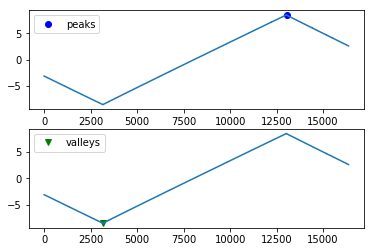

In [9]:
peaks2, _ = find_peaks(v2, prominence=0.01)      # peaks
peaks3, _ = find_peaks(-v2, prominence=0.01)     # valleys
plt.subplot(2,1,1)
plt.plot(peaks2, v2[peaks2], "ob"); plt.plot(v2[15:]); plt.legend(['peaks'])
plt.subplot(2, 1, 2)
plt.plot(peaks3, v2[peaks3], "vg"); plt.plot(v2[15:]); plt.legend(['valleys'])
plt.show()

In [102]:
print(peaks2)
print(peaks3)

extrema = np.sort(np.concatenate((peaks2,peaks3)))
print(extrema)   # a sorted list of peaks and valleys.  We want the data in between each pair of points

[13052]
[3185]
[ 3185 13052]


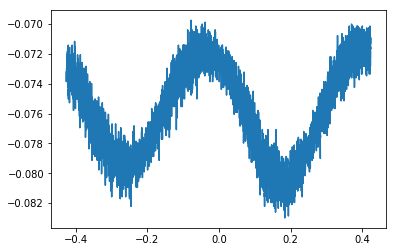

In [83]:
plt.plot(20*v2[extrema[0]:extrema[1]],v1[extrema[0]:extrema[1]])    # Here is the first interval plotted

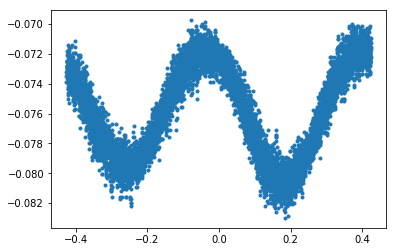

In [84]:
#want to create a bunch of traces for each limb of the triangle wave that we will then fit to.
for i in range(extrema.size-1):
    plt.plot(20*v2[extrema[i]:extrema[i+1]],v1[extrema[i]:extrema[i+1]],".")  #offset for visibility

## Fitting

Now, if you find the period of the sinusoidal oscillations as a function of applied voltage, we can measure the wavelength of the light.  See the instructions, and use the nonlinear curve fit routines as given in lecture 1 https://onq.queensu.ca/d2l/le/content/710132/viewContent/4317848/View .

In [85]:
import pandas as pd

a = np.asarray([t, v1, v2 ])
a.tofile('RKGRawData1.csv',sep=',',format='%10.5f')


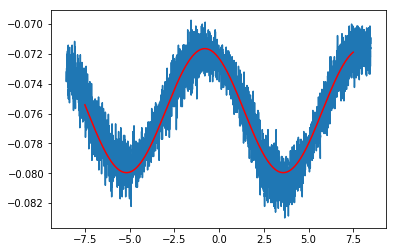

0.716633896489102


In [107]:
from scipy.optimize import curve_fit

# define the fitting function
def fit_func(V2,a,c,omega,phi):
    return a*np.cos(omega*V2 + phi)+c
# count the number of times we run the fit


# Starting parameter values:  A, B, C, omega, tau
#  THIS IS WHAT WE'LL CHANGE TO START THE FIT AT A DIFFERENT POINT
start = np.array([0.07, 0,1,0])


# Perform the fit
popt,pcov=curve_fit(fit_func,v2[extrema[0]:extrema[1]],v1[extrema[0]:extrema[1]],p0=start)


x = np.linspace(-7.5,7.5,1000)
plt.plot(v2[extrema[0]:extrema[1]],v1[extrema[0]:extrema[1]])
plt.plot(x,fit_func(x,popt[0],popt[1],popt[2],popt[3]),'r')

plt.show()

print(popt[2])


In [108]:
dV = 1/popt[2]
dX = dV*28.8e-9 *20
print(dX / 1e-9 ,'nm')

803.7576827190442 nm
